### **Import Libraries**

In [1]:
import pandas as pd  
import numpy as np
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from scipy.optimize import minimize

### **Data Cleanup**

In [2]:
cols= ["Date","Adj Close"]

ADANIPORTS = pd.read_csv("ADANIPORTS.NS.csv")[["Date","Adj Close"]]
GAIL = pd.read_csv("GAIL.NS.csv")["Adj Close"]
HDFCBANK = pd.read_csv("HDFCBANK.NS.csv")["Adj Close"]
INFY = pd.read_csv("INFY.NS.csv")["Adj Close"]
KOTAKBANK = pd.read_csv("KOTAKBANK.NS.csv")["Adj Close"]
RELIANCE = pd.read_csv("RELIANCE.NS.csv")["Adj Close"]
TATASTEEL = pd.read_csv("TATASTEEL.NS.csv")["Adj Close"]

In [3]:
price_data = pd.concat([ADANIPORTS, GAIL, HDFCBANK,INFY, KOTAKBANK,  RELIANCE, TATASTEEL], axis=1)
price_data.columns = ['Date', 'ADANIPORTS', 'GAIL', 'HDFCBANK', 'INFY','KOTAKBANK','RELIANCE', 'TATASTEEL']
price_data = price_data.set_index('Date')
price_data.head()

,ADANIPORTS,GAIL,HDFCBANK,INFY,KOTAKBANK,RELIANCE,TATASTEEL
Date,,,,,,,
2020-04-30,290.100006,92.205490,1001.799988,698.388733,1357.199951,1446.801758,290.763367
2020-05-04,266.350006,90.085823,923.000000,657.588379,1277.800049,1416.405151,266.687439
2020-05-05,263.100006,87.773468,911.450012,657.588379,1238.349976,1441.521729,265.761414
2020-05-06,270.149994,91.242004,946.400024,649.974915,1245.949951,1441.620483,270.732574
2020-05-07,282.399994,88.158859,925.000000,649.047607,1199.800049,1487.215576,268.880585


In [4]:
price_data.count()

ADANIPORTS    250
GAIL          250
HDFCBANK      250
INFY          250
KOTAKBANK     250
RELIANCE      250
TATASTEEL     250
dtype: int64

# **Part A : QUADRITIC PROGRAMMING**


### **Task 1: Efficient Frontier Line**



In [5]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

In [6]:
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [7]:
ret = price_data.pct_change()
cov = ret.cov()*250
er = ret.mean()*250




In [8]:
return_of_stocks = []
return_of_stocks=ret.mean()*250
return_of_stocks

ADANIPORTS    1.005494
GAIL          0.467059
HDFCBANK      0.397069
INFY          0.706191
KOTAKBANK     0.313260
RELIANCE      0.371473
TATASTEEL     1.353889
dtype: float64

In [9]:
from scipy.optimize import minimize
 
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [10]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
 

In [11]:
def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols,
        "Weights": weights
    })
    plt.plot(ef["Volatility"],ef["Returns"])
    plt.xlabel('Volatility')
    plt.ylabel("Returns")
    plt.title("Efficient Frontier Line")
    plt.savefig('QP_EFL')
    return [ef.plot.line(x="Volatility", y="Returns", style='-', legend=False),ef]


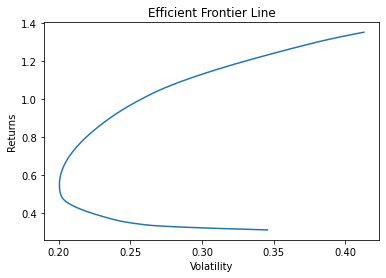

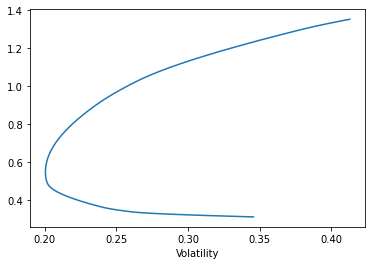

In [12]:
df= plot_ef(500, er, cov)[1]

### **Task 2: Minimum Varience Portfollio**


In [13]:
df['Sharpe_Ratio'] = (df.Returns - 0.05) / df.Volatility
df.head()

,Returns,Volatility,Weights,Sharpe_Ratio
0,0.313260,0.345611,"[0.0, 0.0, 3.2617408502086053e-16, 0.0, 0.9999...",0.761722
1,0.315345,0.335847,"[4.440892098500626e-15, 2.248201624865942e-15,...",0.790077
2,0.317431,0.326472,"[0.0, 0.0, 1.7763568394002505e-15, 0.0, 0.9283...",0.819152
3,0.319516,0.317520,"[0.0, 0.0, 1.0547118733938987e-15, 4.996003610...",0.848815
4,0.321601,0.309028,"[1.6930901125533637e-15, 1.1102230246251565e-1...",0.878888


In [14]:
min_var = df.Weights[df.Volatility.argmin()]

In [15]:
min_var

array([0.04817977, 0.1187478 , 0.08384162, 0.35689849, 0.14283401,
       0.22684913, 0.02264918])

In [16]:
df.Volatility[df.Volatility.argmin()] 

0.20041399032558896

In [17]:
df.Returns[df.Volatility.argmin()]

0.5489132603835559

In [18]:
df.Sharpe_Ratio.max()

3.699774905127927

In [19]:
df.Returns[df.Sharpe_Ratio.argmax()]

1.0306475702803943

In [20]:
df.Volatility[df.Sharpe_Ratio.argmax()]

0.265056008926707

In [21]:
max_sr = df.Weights[df.Sharpe_Ratio.argmax()]
max_sr

array([2.00617697e-01, 2.91108283e-17, 0.00000000e+00, 3.91150398e-01,
       1.00830802e-17, 0.00000000e+00, 4.08231905e-01])

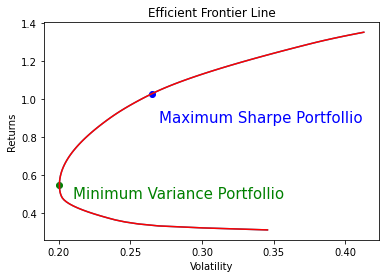

In [22]:
weights = optimal_weights(100, er, cov)
rets = [portfolio_return(w, er) for w in weights]
vols = [portfolio_vol(w, cov) for w in weights]
ef = pd.DataFrame({
  "Returns": rets, 
  "Volatility": vols,
  "Weights": weights
})
plt.plot(ef["Volatility"],ef["Returns"])
plt.xlabel('Volatility')
plt.ylabel("Returns")
plt.title("Efficient Frontier Line")
plt.plot(ef["Volatility"], ef["Returns"], c='r')

plt.scatter(df.Volatility[df.Sharpe_Ratio.argmax()],df.Returns[df.Sharpe_Ratio.argmax()], c='b')
plt.scatter(df.Volatility[df.Volatility.argmin()] ,df.Returns[df.Volatility.argmin()], c='g')

plt.text(0.21, 0.48, 'Minimum Variance Portfollio', fontsize=15,  color='g')
plt.text(0.27, 0.88, 'Maximum Sharpe Portfollio', fontsize=15,  color='b')
plt.savefig('QP_EFL_with_points')



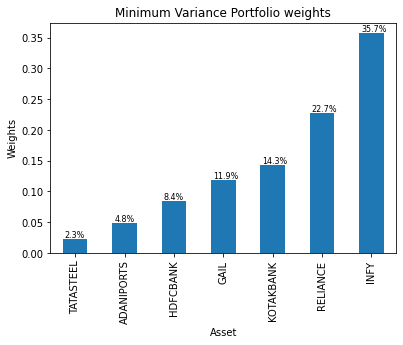

In [23]:
names = price_data.columns

min_var = pd.Series(min_var, index=names)
min_var = min_var.sort_values()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Minimum Variance Portfolio weights")
min_var.plot(kind = 'bar')
for index,data in enumerate(min_var):
    plt.text(x=index-0.21 , y = data+0.003 , s=f"{round(data*100,1)}%" , fontdict=dict(fontsize=8))
plt.savefig('QP_MVP.png',  bbox_inches = "tight")
plt.show();



### **Task 3: Asset Beta**


In [24]:
rf = 0.05

In [25]:
pip install yfinance

In [26]:
price_data.head(1)

,ADANIPORTS,GAIL,HDFCBANK,INFY,KOTAKBANK,RELIANCE,TATASTEEL
Date,,,,,,,
2020-04-30,290.100006,92.20549,1001.799988,698.388733,1357.199951,1446.801758,290.763367


In [27]:
price_data.tail(1)

,ADANIPORTS,GAIL,HDFCBANK,INFY,KOTAKBANK,RELIANCE,TATASTEEL
Date,,,,,,,
2021-04-30,732.450012,137.449997,1413.900024,1357.650024,1750.050049,1994.699951,1031.550049


In [28]:
import yfinance as yf 
from pandas_datareader import data as pdr

stock_m = ['^BSESN']
stock_N = ['^CRSLDX']

start = pd.to_datetime('2020-04-30') 
end = pd.to_datetime('2021-04-30')

index = pdr.get_data_yahoo(stock_m, start=start, end=end)['Adj Close']
nifty = pdr.get_data_yahoo(stock_N, start=start, end=end)['Adj Close']

In [29]:
nifty.head()

Symbols,^CRSLDX
Date,
2020-04-30,8012.899902
2020-05-04,7596.899902
2020-05-05,7523.049805
2020-05-06,7575.500000
2020-05-07,7520.850098


In [30]:
index.head()

Symbols,^BSESN
Date,
2020-04-30,33717.621094
2020-05-04,31715.349609
2020-05-05,31453.509766
2020-05-06,31685.750000
2020-05-07,31443.380859


In [31]:
log_ret_index = index.pct_change()
log_ret_nifty = nifty.pct_change()

log_ret_index.tail()


Symbols,^BSESN
Date,
2021-04-26,0.010612
2021-04-27,0.011524
2021-04-28,0.016135
2021-04-29,0.000645
2021-04-30,-0.019764


In [32]:
log_ret_nifty.tail()

Symbols,^CRSLDX
Date,
2021-04-26,0.009190
2021-04-27,0.011926
2021-04-28,0.012570
2021-04-29,0.001186
2021-04-30,-0.013441


In [33]:
log_ret_nifty.mean()*250

Symbols
^CRSLDX    0.454654
dtype: float64

In [34]:
log_ret_index.mean()*250

Symbols
^BSESN    0.392499
dtype: float64

In [35]:
ret.tail()

,ADANIPORTS,GAIL,HDFCBANK,INFY,KOTAKBANK,RELIANCE,TATASTEEL
Date,,,,,,,
2021-04-26,0.007445,0.004637,-0.006612,0.007310,0.014675,0.017591,0.016368
2021-04-27,0.025180,0.011923,0.024131,0.003684,-0.005314,0.026215,0.039330
2021-04-28,-0.003871,0.013683,0.026482,0.005562,0.034937,0.004350,-0.006494
2021-04-29,0.000670,0.010874,-0.002912,0.000258,-0.003561,0.013393,0.061715
2021-04-30,-0.019150,0.019659,-0.039796,0.000958,-0.030443,-0.014501,0.000194


In [36]:
beta_data = pd.concat([log_ret_index,ret], axis=1)
beta_data.dropna(inplace=True)

beta_data_1 = pd.concat([log_ret_nifty,ret], axis=1)
beta_data_1.dropna(inplace=True)

beta_data.tail()

,^BSESN,ADANIPORTS,GAIL,HDFCBANK,INFY,KOTAKBANK,RELIANCE,TATASTEEL
Date,,,,,,,,
2021-04-26,0.010612,0.007445,0.004637,-0.006612,0.007310,0.014675,0.017591,0.016368
2021-04-27,0.011524,0.025180,0.011923,0.024131,0.003684,-0.005314,0.026215,0.039330
2021-04-28,0.016135,-0.003871,0.013683,0.026482,0.005562,0.034937,0.004350,-0.006494
2021-04-29,0.000645,0.000670,0.010874,-0.002912,0.000258,-0.003561,0.013393,0.061715
2021-04-30,-0.019764,-0.019150,0.019659,-0.039796,0.000958,-0.030443,-0.014501,0.000194


In [37]:
beta_array =[] 
beta_array.append((beta_data[['ADANIPORTS','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['GAIL','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['HDFCBANK','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['INFY','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['KOTAKBANK','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['RELIANCE','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])
beta_array.append((beta_data[['TATASTEEL','^BSESN']].cov()/beta_data['^BSESN'].var()).iloc[0].iloc[1])

beta_array_1 =[] 
beta_array_1.append((beta_data_1[['ADANIPORTS','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['GAIL','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['HDFCBANK','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['INFY','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['KOTAKBANK','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['RELIANCE','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])
beta_array_1.append((beta_data_1[['TATASTEEL','^CRSLDX']].cov()/beta_data_1['^CRSLDX'].var()).iloc[0].iloc[1])




beta_array


[1.0468050957731707,
 0.880793594790211,
 1.3015744557450015,
 0.6670153988321066,
 1.1598968460787253,
 0.8698206660575702,
 1.1091874459476447]

In [38]:
beta_array_1

[1.2500613567812389,
 1.0754397899704449,
 1.29855099517806,
 0.6825133747202141,
 1.1980532214609834,
 0.8893632159369468,
 1.3568153265743441]

In [39]:
beta_mvp_sensex = np.sum(beta_array*min_var)
beta_mvp_sensex

1.0133365372167384

In [40]:
beta_mvp_nifty = np.sum(beta_array_1*min_var)
beta_mvp_nifty

1.127166247946974

In [41]:
np.sum(beta_array*df.Weights[df.Sharpe_Ratio.argmax()])

0.9237166701313978

In [42]:
np.sum(beta_array_1*df.Weights[df.Sharpe_Ratio.argmax()])

1.0716451139019516

In [43]:
df.Weights[df.Sharpe_Ratio.argmax()]

array([2.00617697e-01, 2.91108283e-17, 0.00000000e+00, 3.91150398e-01,
       1.00830802e-17, 0.00000000e+00, 4.08231905e-01])

In [44]:
market_return_array = index.pct_change()
market_return = market_return_array['^BSESN'].mean()*250
market_return

0.392499243540008

In [45]:
market_return_array_1 = nifty.pct_change()
market_return_1 = market_return_array_1['^CRSLDX'].mean()*250
market_return_1

0.45465381688519463

In [46]:
return_of_stocks = []
return_of_stocks=(ret*250).mean()
return_of_stocks

ADANIPORTS    1.005494
GAIL          0.467059
HDFCBANK      0.397069
INFY          0.706191
KOTAKBANK     0.313260
RELIANCE      0.371473
TATASTEEL     1.353889
dtype: float64

In [47]:
return_of_portfollio = np.sum(return_of_stocks*min_var)
return_of_portfollio

0.5489132603835559

### **Task 4: Security Market Line**


In [48]:
cols = ret.columns
cols

Index(['ADANIPORTS', 'GAIL', 'HDFCBANK', 'INFY', 'KOTAKBANK', 'RELIANCE',
       'TATASTEEL'],
      dtype='object')

In [49]:
market_return

0.392499243540008

In [50]:
market_return_1

0.45465381688519463

In [51]:
return_of_portfollio

0.5489132603835559

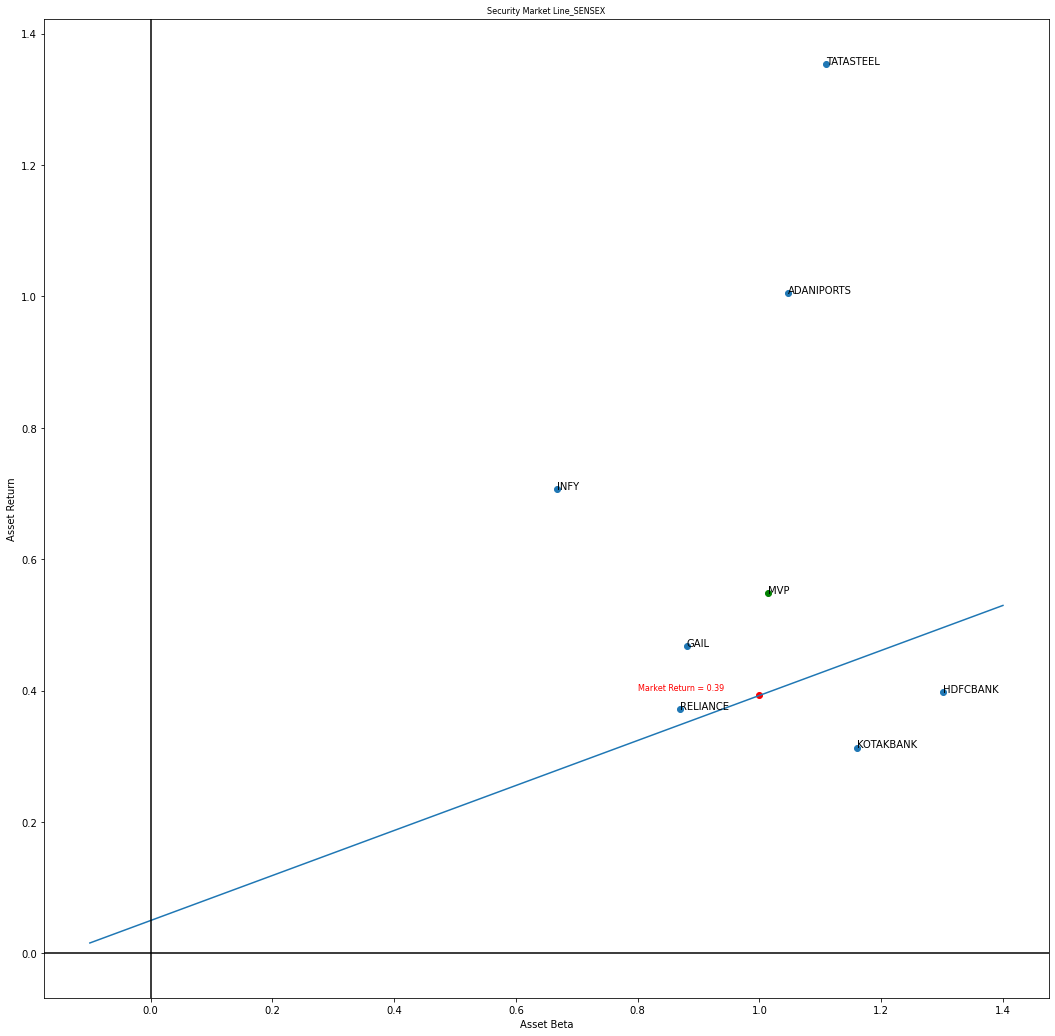

In [52]:
plt.figure(figsize=(18,18))

betas = [x/10 for x in range(-1,15)]
assetReturns = [rf+(market_return-rf)*x for x in betas]
plt.plot(betas,assetReturns)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(1, market_return,c='r')
plt.xlabel("Asset Beta")
plt.ylabel("Asset Return")

plt.text(0.8, 0.4, 'Market Return = 0.39 ', fontsize=8,  color='r')
plt.title('Security Market Line_SENSEX', fontsize=8)


plt.scatter(beta_array, return_of_stocks)
for i in range(7):
    plt.annotate(cols[i], ( beta_array[i],return_of_stocks[i]))

plt.scatter(beta_mvp_sensex, return_of_portfollio,c='g')
plt.annotate('MVP', (beta_mvp_sensex, return_of_portfollio), )

plt.savefig('Market_SML_BSE_SENSEX.png', dpi = 300)

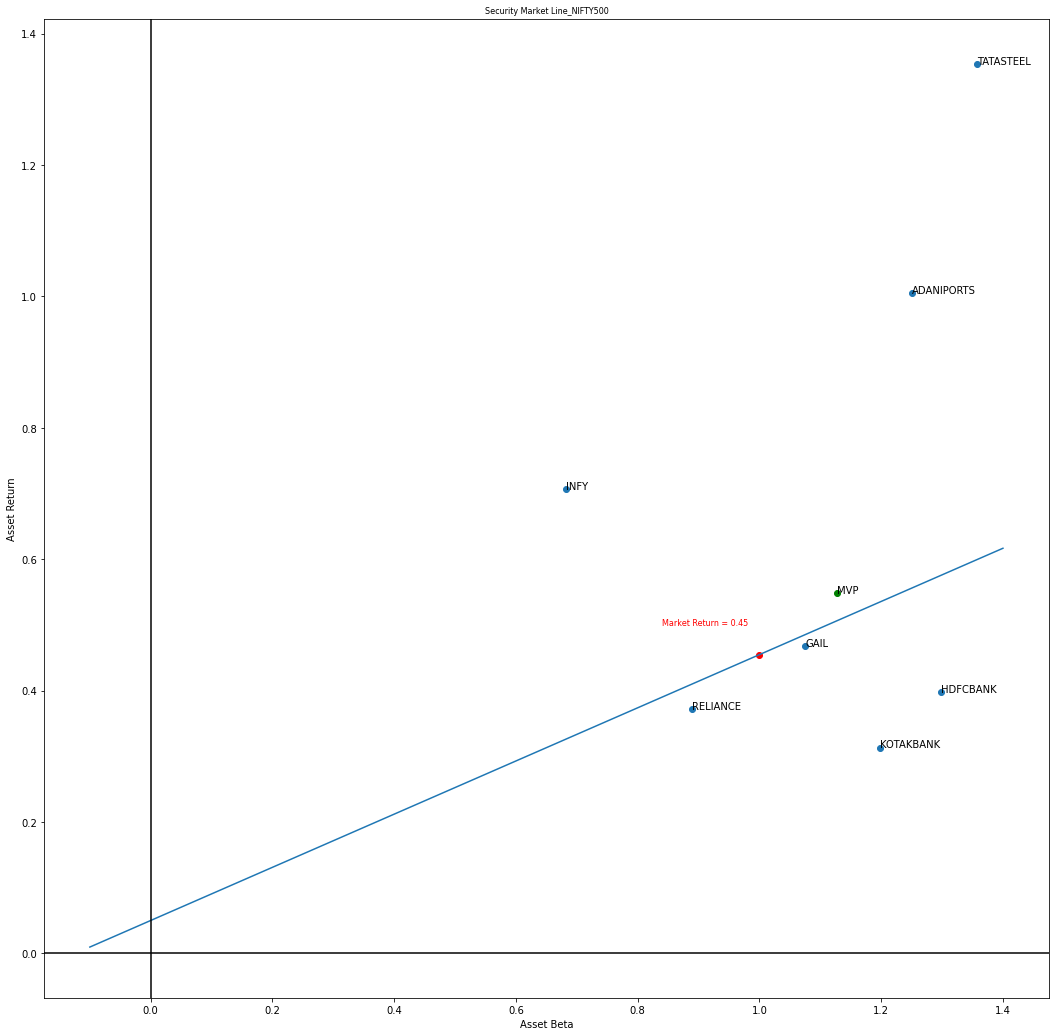

In [53]:
plt.figure(figsize=(18,18))

betas = [x/10 for x in range(-1,15)]
assetReturns = [rf+(market_return_1-rf)*x for x in betas]
plt.plot(betas,assetReturns)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(1, market_return_1,c='r')
plt.xlabel("Asset Beta")
plt.ylabel("Asset Return")

plt.text(0.84, 0.5, 'Market Return = 0.45 ', fontsize=8,  color='r')
plt.title('Security Market Line_NIFTY500', fontsize=8)


plt.scatter(beta_array_1, return_of_stocks)
for i in range(7):
    plt.annotate(cols[i], ( beta_array_1[i],return_of_stocks[i]))

plt.scatter(beta_mvp_nifty, return_of_portfollio,c='g')
plt.annotate('MVP', (beta_mvp_nifty, return_of_portfollio), )

plt.savefig('Market_SML_NIFTY_500.png', dpi = 300)

### **Task 5: Capital Allocation Market Line**



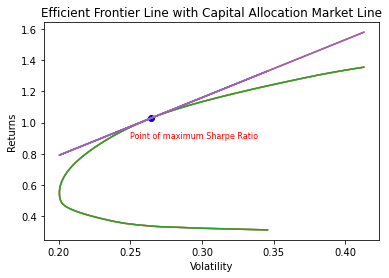

In [54]:
weights = optimal_weights(100, er, cov)
rets = [portfolio_return(w, er) for w in weights]
vols = [portfolio_vol(w, cov) for w in weights]
ef = pd.DataFrame({
  "Returns": rets, 
  "Volatility": vols,
  "Weights": weights
})
ef["Sharpe_Ratio"]=(ef.Returns - 0.05) / ef.Volatility
plt.plot(ef["Volatility"],ef["Returns"])
plt.xlabel('Volatility')
plt.ylabel("Returns")
plt.title("Efficient Frontier Line with Capital Allocation Market Line")
plt.plot(ef["Volatility"], ef["Returns"])
plt.plot(ef["Volatility"], ef["Returns"])

plt.scatter(ef.Volatility[ef["Sharpe_Ratio"].argmax()],ef.Returns[ef["Sharpe_Ratio"].argmax()], c='b')
X = [0,ef.Volatility[ef["Sharpe_Ratio"].argmax()]]
Y = [0.05, ef.Returns[ef["Sharpe_Ratio"].argmax()]]
m = (Y[1]-Y[0]) / (X[1] - X[0])

rm = ef.Returns[ef["Sharpe_Ratio"].argmax()]
assetReturns = [m*x+0.05  for x in ef.Volatility]
#plt.text(0.21, 01.35, 'Capital Allocation Market Line', fontsize=15,  color='r')
plt.plot(ef.Volatility,assetReturns)

assetReturns = [m*x+0.05  for x in ef.Volatility]
#plt.text(0.21, 01.35, 'Capital Allocation Market Line', fontsize=15,  color='r')
plt.plot(ef.Volatility,assetReturns)

plt.text(0.25, 0.9, 'Point of maximum Sharpe Ratio', fontsize=8,  color='r')


plt.savefig('Capital Allocation Market Line')

## **Summary of Results - Quadritic Programming**



*   **Minimum Variance Portfollio** :
TATASTEEL     0.022649
ADANIPORTS    0.048180
HDFCBANK      0.083842
GAIL          0.118748
KOTAKBANK     0.142834
RELIANCE      0.226849
INFY          0.356898

*  **Minimum Variance Portfollio Percentages** (Graph Attached)
        *   TATA STEEL : 2.2%
        *   ADANIPORTS : 4.8% 
        *   HDFCBANK : 8.3%
        *   GAIL : 11.8% 
        *   KOTABANK : 14.2%
        *   RELIANCE : 22.6%
        *   INFY : 35.6%

*   **Maximum Sharpe Portfollio** : [2.00617697e-01, 2.91108283e-17, 0.00000000e+00, 3.91150398e-01,1.00830802e-17, 0.00000000e+00, 4.08231905e-01] in alphabetical order of stocks

        
*   **Efficiency Frontier Line**
        *   Minimum Volatility (Variance) : 0.200
        *   Return at minimum Volatility: 0.548
        *   Maximum Sharpe Ratio : 3.699
        *   Volatility at maximum Sharpe Ratio : 0.26
        *   Return at maximum Sharpe Ratio : 1.03

      
*  **Beta** of each stock in alphabatical order wrt Sensex:
[1.04, 0.88, 1.30, 0.67, 1.15, 0.87, 1.10]

*  **Beta** of each stock in alphabatical order wrt Nifty500:
[1.25, 1.07, 1.30, 0.68, 1.19, 0.88, 1.35]

*   **Beta of the Minimum Variance Portfollio (Sensex)** : 1.0

*   **Beta of the Minimum Variance Portfollio (Nifty500)** : 1.1

*   **Security Market Line : Sensex** 
        *  Slope : 0.34
        *  Y-Intercept : 0.050 (Risk Free Rate)

*   **Security Market Line : Nifty500** 
        *  Slope : 0.40
        *  Y-Intercept : 0.050 (Risk Free Rate)

*   **Capital Allocation Market Market Line** 
        *  Slope : 3.353
        *  Y-Intercept : 0.050 (Risk Free Rate)
